# Reduction Charge Transfer (RCT) : library charges for all
Fixed templates for residue-wise atomic partial charges ("library charges") are an effective method for significantly \ reducing the time needed to parameterize a molecular system, in exchange for a trivial amount of space

In [our manuscript](https://pubs.acs.org/doi/10.1021/acs.jcim.3c01691), we describe the approach of RCT, a method for \ 
bootstrapping up to these templates for arbitrary residue chemistry (not just amino-acid residues). 

Here we lay out how to implement this protocol using [polymerist](https://github.com/timbernat/polymerist) tools

![words](graphics/rct_schematic.png)

In [1]:
from pathlib import Path

RCT_DIR = Path('RCT_demo_files')
RCT_DIR.mkdir(exist_ok=True)

## 0) Selecting chemistry
We will use polyacrylamide (PAAm) as a simple example system here, with quick-and-dirty molecule setup shown

In [2]:
polymer_name : str = 'PAAm'
residues : dict[str, str] = { # specify residue names and chemistry (as vanilla SMILES)
    'PAAm_head' : '*CCC(=O)[NH2]',
    'PAAm_tail' : '*C(C(=O)[NH2])C',
    'PAAm_mid'  : '*C(C(=O)[NH2])C*',
}
term_orient : dict[str, str] = { # specify end group behavior;  keys here must he either "head" or "tail"
    'head' : 'PAAm_head',
    'tail' : 'PAAm_tail',
}  

Cleaned 12 SMARTS atom query aberrations introduced by RDKit
Cleaned 12 SMARTS atom query aberrations introduced by RDKit
Cleaned 12 SMARTS atom query aberrations introduced by RDKit


PAAm_head


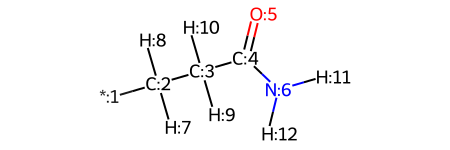

PAAm_tail


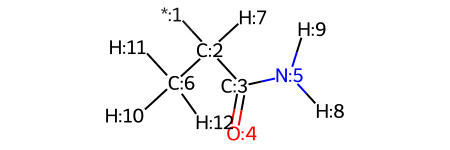

PAAm_mid


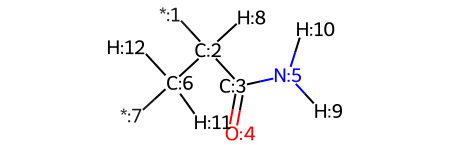

In [3]:
from polymerist.genutils.fileutils.pathutils import assemble_path

from polymerist.polymers.monomers import MonomerGroup
from polymerist.polymers.monomers.specification import expanded_SMILES, compliant_mol_SMARTS


polymer_dir = RCT_DIR / polymer_name
polymer_dir.mkdir(exist_ok=True)

residues = { # upconvert to specification-compliant SMARTS
    name : compliant_mol_SMARTS(expanded_SMILES(smiles, assign_map_nums=True))
        for name, smiles in residues.items()
}

monogrp = MonomerGroup(monomers=residues, term_orient=term_orient)
for name, mol in monogrp.iter_rdmols():
    print(name)
    display(mol)

residues_path = assemble_path(polymer_dir, polymer_name, postfix='residues', extension='json')
monogrp.to_file(residues_path)

## 1) Reduction
Build an oligomer which can be explicitly charged with a semi-empirical method

In [4]:
from openff.toolkit import Molecule, Topology

from polymerist.polymers.building import build_linear_polymer, mbmol_to_openmm_pdb
from polymerist.polymers.estimation import estimate_n_monomers_infimum

from polymerist.mdtools.openfftools.topology import topology_to_sdf, topology_from_sdf, get_largest_offmol
from polymerist.mdtools.openfftools.partition import partition


def build_openff_polymer(
        monomers : MonomerGroup,
        n_monomers : int,
        outdir : Path,
        polymer_name : str,
        postfix : str='',
        **kwargs
    ) -> Molecule:
    '''
    Helper function to aid this demo (and your polymer studies :P)

    Generates PDB with coordinates, loads as OpenFF object, and assign residues metadata
    Caches PDB and SDF snapshots along the way and returns the final polymer structure as an OpenFF Molecule
    '''
    # assign coordinates using mBuild backend, save to PDB file
    chain = build_linear_polymer(monomers=monomers, n_monomers=n_monomers, **kwargs)
    redux_path_pdb = assemble_path(polymer_dir, polymer_name, postfix=postfix, extension='pdb')
    mbmol_to_openmm_pdb(redux_path_pdb, chain)

    # load as OpenFF object and assign residue info
    offtop = Topology.from_pdb(redux_path_pdb, _custom_substructures=monomers.monomers)
    was_partitioned = partition(offtop)
    assert(was_partitioned)

    redux_path_sdf : Path = assemble_path(outdir, polymer_name, postfix=postfix, extension='sdf')
    topology_to_sdf(redux_path_sdf, offtop) # cache so we don't have to repartition in the future

    return get_largest_offmol(offtop) # extract molecule object and return

[20:53:50] WARNING: not removing hydrogen atom with dummy atom neighbors


In [5]:
n_atoms_max = 150 # this is a practical upper bound which balances accuracy vs speed of AM1-BCC

oligomer : Molecule = build_openff_polymer(
    monogrp, 
    n_monomers=estimate_n_monomers_infimum(monogrp, n_atoms_max), # guarantees the resulting molecule is not bigger than the prescribed max  
    outdir=polymer_dir,
    polymer_name=polymer_name,
    postfix='reduced',
    sequence='A', # linear homopolymer in the middle (end groups are implicit)
    energy_minimize=True, # UFF minimization helps avoid unphysical conformers for AM1-BCC    
)
oligomer.visualize(backend='nglview')

/home/timber/miniconda3/envs/polymerist-env/lib/python3.11/site-packages/mbuild/compound.py:2643: UserWarning: Performing energy minimization using the Open Babel package. Please refer to the documentation to find the appropriate citations for Open Babel and the UFF force field
  warn(


NGLWidget()

## 2) Charge
Assign partial charges with explicit method and generate library charge templates

You can opt for a "quick-and-dirty" charging method to get the gist of the approach, or go for full AM1-BCC ELF10 to get the fully experience; \
Just note that the latter will take a much longer time, especially depending on the complexity of the system!

In [6]:
from polymerist.mdtools.openfftools.partialcharge.molchargers import (
    NAGLCharger,  # requires having OpenFF NAGL installed
    ABE10Charger, # requires having OpenEye toolkits installed and licensed
)
from polymerist.mdtools.openfftools.partialcharge.rescharge.calculation import (
    compute_residue_charges,
    ChargesByResidue,
    UniformDistributionStrategy,
)


quick_and_dirty : bool = True # whether to use full-blown AM1-BCC ELF10 or a quicker analogue just for proof-of-concept

# assign partial charges
mol_charger = NAGLCharger() if quick_and_dirty else ABE10Charger()
oligomer_charged : Molecule = mol_charger.charge_molecule(oligomer)

cmol_path_sdf : Path = assemble_path(polymer_dir, polymer_name, postfix='reduced_charged', extension='sdf')
topology_to_sdf(cmol_path_sdf, oligomer_charged.to_topology()) # similarly, cache molecule with charges

# Extract library charges from partial charge and residue info on oligomer
lib_charges : ChargesByResidue = compute_residue_charges(oligomer_charged, monogrp, cds=UniformDistributionStrategy())
lib_chg_path : Path = assemble_path(polymer_dir, polymer_name, postfix='library_charges', extension='json')
lib_charges.to_file(lib_chg_path)

## 3) Transfer
Apply library charges to a much larger molecule

In [7]:
from polymerist.mdtools.openfftools.partialcharge.rescharge.interface import LibraryCharger


n_monomers : int = 100 # NOTE that this is the total number of repeat units (NOT atoms) in the larger polymer

# build larger molecule - might take a second, depending on how big you've specified it to be
polymer = build_openff_polymer(
    monogrp, 
    n_monomers=n_monomers, # guarantees the resulting molecule is not bigger than the prescribed max  
    outdir=polymer_dir,
    polymer_name=polymer_name,
    postfix=f'{n_monomers}-mer',
    sequence='A', # linear homopolymer in the middle (end groups are implicit)
    energy_minimize=True, # UFF minimization helps avoid unphysical conformers for AM1-BCC    
)
polymer.visualize(backend='nglview')

# load and assign library charges to it
lib_charges = ChargesByResidue.from_file(lib_chg_path)
lib_charger = LibraryCharger(lib_charges)

polymer_charged = lib_charger.charge_molecule(polymer)
polymer_path_sdf : Path = assemble_path(polymer_dir, polymer_name, postfix='RCT_charged', extension='sdf')
topology_to_sdf(polymer_path_sdf, polymer_charged.to_topology())

/home/timber/miniconda3/envs/polymerist-env/lib/python3.11/site-packages/mbuild/compound.py:2643: UserWarning: Performing energy minimization using the Open Babel package. Please refer to the documentation to find the appropriate citations for Open Babel and the UFF force field
  warn(


## That's all there is to it!